<a href="https://colab.research.google.com/github/Lmarra1/sympy-workshop-UC3M-2025/blob/main/pendulum_ekf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import display, Math

In [51]:
# Physical variables
t        = sp.Symbol('t', real=True)
m, g, L  = sp.symbols('m g L', positive=True)
theta_var, omega_var = sp.symbols('theta omega', real=True)
vars_vec = sp.Matrix([theta_var, omega_var])

# Continuous-Time Dynamics (f)
f_theta = omega_var
f_omega = - (g/L) * sp.sin(theta_var)
f_continuous = sp.Matrix([f_theta, f_omega])

# Continuous-Time Jacobian (J)
J_continuous = f_continuous.jacobian(vars_vec)

print("\nContinuous-Time Dynamics:\n")
display(Math(r'\dot{\theta} = ' + sp.latex(f_continuous[0])))
display(Math(r'\dot{\omega} = ' + sp.latex(f_continuous[1])))

print("\nContinuous-Time Jacobian (J = d(f)/dx):\n")
display(J_continuous)

# --- Discrete-Time Dynamics (Forward Euler) ---
dt_sym = sp.symbols('dt', positive=True, real=True)
f_discrete = vars_vec + f_continuous * dt_sym
J_discrete = f_discrete.jacobian(vars_vec)
J_discrete_2 = np.eye(2) + J_continuous * dt_sym

print("\nDiscrete-Time Jacobian:\n")
display(J_discrete)

print("\nDiscrete-Time Jacobian (second option):\n")
display(J_discrete_2)

# --- GENERALIZED: Measurement Model ---
case = 2
if case == 1:
    print("\nUsing Measurement Model 1: direct measurementr of theta")
    h_measurement = sp.Matrix([theta_var])
else:
    print("\nUsing Measurement Model 2: Cartesian (x,y)")
    h_measurement = sp.Matrix([
        L * sp.sin(theta_var),
        L - L * sp.cos(theta_var)
    ])


# Measurement Jacobian (H = dh/dx)
H_measurement = h_measurement.jacobian(vars_vec)

print("\nMeasurement Function (h):\n")
display(h_measurement)

print("\nMeasurement function Jacobian (H = dh/dx):\n")
display(H_measurement)



Continuous-Time Dynamics:



<IPython.core.display.Math object>

<IPython.core.display.Math object>


Continuous-Time Jacobian (J = d(f)/dx):



Matrix([
[              0, 1],
[-g*cos(theta)/L, 0]])


Discrete-Time Jacobian:



Matrix([
[                 1, dt],
[-dt*g*cos(theta)/L,  1]])


Discrete-Time Jacobian (second option):



Matrix([
[               1.0,  dt],
[-dt*g*cos(theta)/L, 1.0]])


Using Measurement Model 2: Cartesian (x,y)

Measurement Function (h):



Matrix([
[     L*sin(theta)],
[-L*cos(theta) + L]])


Measurement function Jacobian (H = dh/dx):



Matrix([
[L*cos(theta), 0],
[L*sin(theta), 0]])

In [52]:
theta = sp.Function('theta')(t)
theta_linear_eq = sp.Eq(theta.diff(t,2) + (g/L)*theta, 0)
sol_linear = sp.dsolve(theta_linear_eq, theta)

# Small-angle IC
theta0_val = 0.6
omega0_val = 0.0
C1, C2 = sp.symbols('C1 C2')
theta_sol = sol_linear.rhs
ics = sp.solve([theta_sol.subs(t,0) - theta0_val,
                theta_sol.diff(t).subs(t,0) - omega0_val], (C1,C2))
theta_sol = theta_sol.subs(ics)
theta_linear_func = sp.lambdify(t, theta_sol.subs({g:9.81, L:1.0}), 'numpy')

print("\nLinearized pendulum equation:\n")
display(theta_linear_eq)

print("\nSolution of the linearized pendulum equation:\n")
display(sol_linear)

print("\nSolution of the constants for specified theta_0 and omega_0:\n")
display(ics)

print("\nSolution of the linearized pendulum equation for specified theta_0 and omega_0:\n")
display(theta_sol)


Linearized pendulum equation:



Eq(Derivative(theta(t), (t, 2)) + g*theta(t)/L, 0)


Solution of the linearized pendulum equation:



Eq(theta(t), C1*sin(sqrt(g)*t/sqrt(L)) + C2*cos(sqrt(g)*t/sqrt(L)))


Solution of the constants for specified theta_0 and omega_0:



{C1: 0.0, C2: 0.600000000000000}


Solution of the linearized pendulum equation for specified theta_0 and omega_0:



0.6*cos(sqrt(g)*t/sqrt(L))

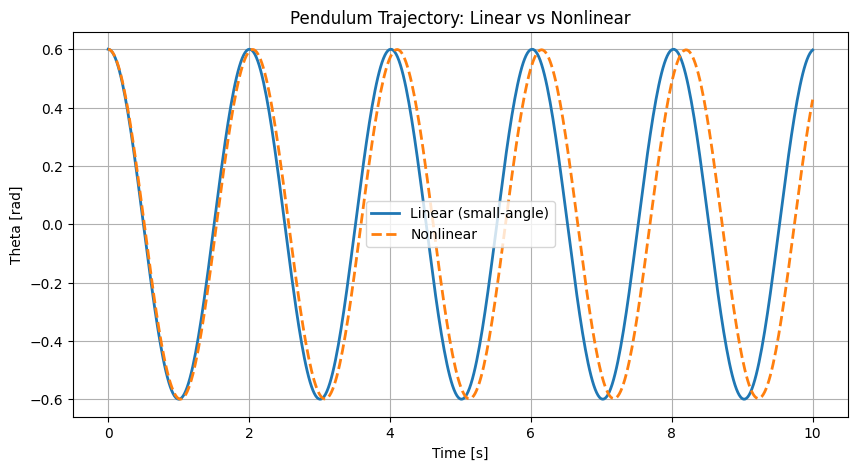

In [53]:
def nonlinear_pendulum(t, y, g=9.81, L=1.0):
    theta, omega = y
    return [omega, - (g/L) * np.sin(theta)]

t_span = (0, 10)
t_eval = np.linspace(0, 10, 500)
y0 = [theta0_val, omega0_val]

sol_nl = solve_ivp(nonlinear_pendulum, t_span, y0, t_eval=t_eval)

# (Plotting this comparison is optional, can be commented out)
plt.figure(figsize=(10,5))
plt.plot(t_eval, theta_linear_func(t_eval), label='Linear (small-angle)', lw=2)
plt.plot(sol_nl.t, sol_nl.y[0], label='Nonlinear', lw=2, linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Theta [rad]')
plt.title('Pendulum Trajectory: Linear vs Nonlinear')
plt.legend()
plt.grid(True)
plt.show()



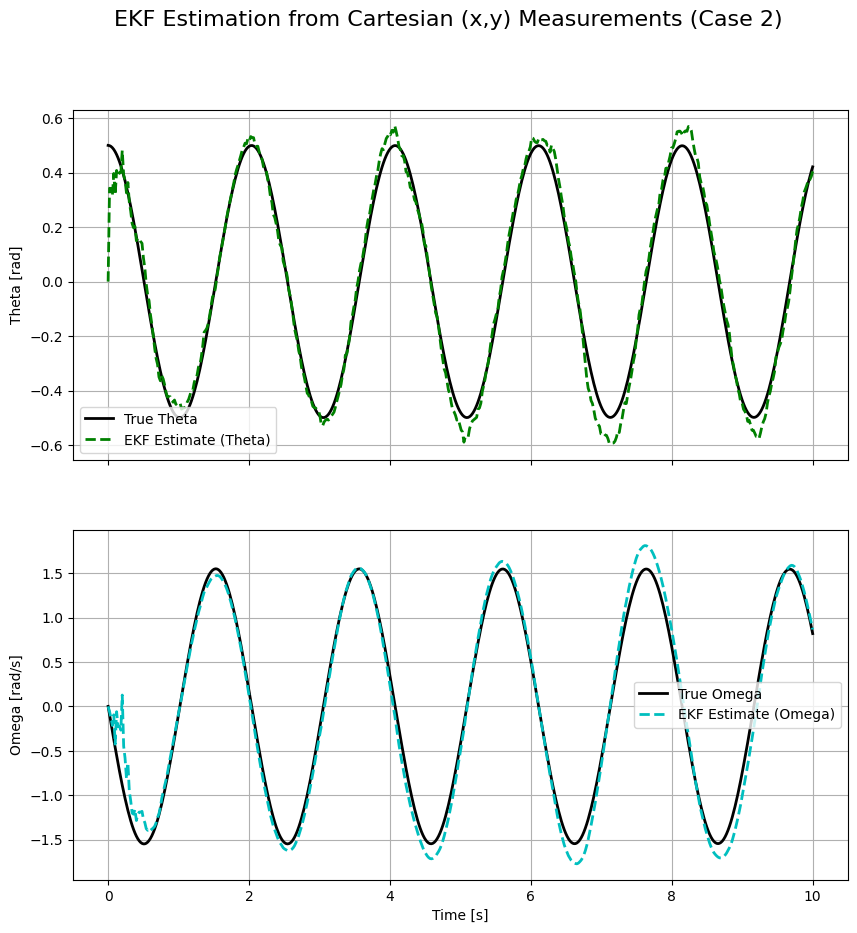

In [54]:
np.random.seed(1)
g_val = 9.81
L_val = 1.0

# New trajectory initial condition
theta0_new = 0.5
omega0_new = 0.0
y0_new = [theta0_new, omega0_new]

t_span = (0, 10)
t_eval = np.linspace(0, 10, 500)

# Integrate new nonlinear trajectory
sol_nl_new = solve_ivp(nonlinear_pendulum, t_span, y0_new, t_eval=t_eval)

# --- GENERALIZED: Simulate noisy measurements ---
measurement_noise_std = 0.2

if case == 1:
    # Case 1: Measure theta directly
    theta_true = sol_nl_new.y[0]
    theta_meas_new = theta_true + measurement_noise_std * np.random.randn(len(t_eval))
else:
    # Case 2: Measure x and y
    theta_true = sol_nl_new.y[0]
    x_true = L_val * np.sin(theta_true)
    y_true = L_val * (1.0 - np.cos(theta_true))
    # Add noise to both
    x_meas = x_true + measurement_noise_std * np.random.randn(len(t_eval))
    y_meas = y_true + measurement_noise_std * np.random.randn(len(t_eval))

# EKF parameters
dt = t_eval[1] - t_eval[0]
n_steps = len(t_eval)
x_est_new = np.zeros((2, n_steps))
P = np.eye(2) * 1.0      # initial covariance
Q = np.eye(2) * 1e-4     # process noise (same for both)

# --- GENERALIZED: Measurement noise matrix R ---
if case == 1:
    R = np.array([[measurement_noise_std**2]]) # 1x1 matrix
else:
    R = np.eye(2) * (measurement_noise_std**2) # 2x2 matrix

# Initial estimate deliberately wrong
x_est_new[:,0] = [0.0, 0.0]

# --- EKF helper functions (Lambdify from SymPy) ---
# These functions are now generic, thanks to SymPy
# They will handle a 1D or 2D measurement model automatically

# Dynamics functions
f_numeric_sym = sp.lambdify(
    (theta_var, omega_var, dt_sym),
    f_discrete.subs({g: g_val, L: L_val}),
    'numpy'
)
F_jacobian_sym = sp.lambdify(
    (theta_var, omega_var, dt_sym),
    J_discrete.subs({g: g_val, L: L_val}),
    'numpy'
)

# Measurement functions
h_numeric_sym = sp.lambdify(
    (theta_var, omega_var),
    h_measurement.subs({g: g_val, L: L_val}),
    'numpy'
)
H_jacobian_sym = sp.lambdify(
    (theta_var, omega_var),
    H_measurement.subs({g: g_val, L: L_val}),
    'numpy'
)

# --- EKF loop (Generalized) ---
for k in range(1, n_steps):
    # Get previous estimate
    theta_prev, omega_prev = x_est_new[:, k-1]

    # --- Prediction (Identical for both cases) ---
    F = F_jacobian_sym(theta_prev, omega_prev, dt)
    x_pred_matrix = f_numeric_sym(theta_prev, omega_prev, dt)
    x_pred = x_pred_matrix.flatten()
    P_pred = F @ P @ F.T + Q

    # --- Update (Generalized) ---

    # Calculate measurement Jacobian H at the predicted state
    H_k = H_jacobian_sym(x_pred[0], x_pred[1]) # (1,2) or (2,2)

    # Calculate predicted measurement h(x_pred)
    h_x_pred_matrix = h_numeric_sym(x_pred[0], x_pred[1])
    h_x_pred = h_x_pred_matrix.flatten() # 1D array, len 1 or 2

    # --- GENERALIZED: Get current measurement vector y_k ---
    if case == 1:
        y_k = np.array([theta_meas_new[k]]) # 1D array, len 1
    else:
        y_k = np.array([x_meas[k], y_meas[k]]) # 1D array, len 2

    # Innovation (measurement residual)
    y_tilde = y_k - h_x_pred

    # The rest of the math works for both cases thanks to
    # the correct dimensions of H_k, P_pred, and R.

    # Innovation covariance
    S = H_k @ P_pred @ H_k.T + R # (1x1) or (2x2)

    # Kalman Gain
    K = P_pred @ H_k.T @ np.linalg.inv(S) # (2x1) or (2x2)

    # Update state estimate
    x_est_new[:,k] = x_pred + K @ y_tilde # K @ y_tilde is (2,1)

    # Update covariance estimate
    P = (np.eye(2) - K @ H_k) @ P_pred

# --- Plot EKF (Generalized) ---
if case == 1:
    title_str = 'EKF Estimation from Direct Theta Measurement (Case 1)'
else:
    title_str = 'EKF Estimation from Cartesian (x,y) Measurements (Case 2)'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
fig.suptitle(title_str, fontsize=16)

# Plot Theta (State 1)
ax1.plot(t_eval, sol_nl_new.y[0], 'k-', lw=2, label='True Theta')
ax1.plot(t_eval, x_est_new[0,:], 'g--', lw=2, label='EKF Estimate (Theta)')
if case == 1:
    # Only plot measurements if they are in the same units
    ax1.plot(t_eval, theta_meas_new, 'r.', alpha=0.3, label='Measurements')
ax1.set_ylabel('Theta [rad]')
ax1.legend()
ax1.grid(True)

# Plot Omega (State 2)
ax2.plot(t_eval, sol_nl_new.y[1], 'k-', lw=2, label='True Omega')
ax2.plot(t_eval, x_est_new[1,:], 'c--', lw=2, label='EKF Estimate (Omega)')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Omega [rad/s]')
ax2.legend()
ax2.grid(True)

plt.show()














